# Visualizing Model Output - Part 2

#### Overview
In this notebook, we will continue looking at ways to visualize ocean model output. As in previous lessons, we will use output from the ECCO Ocean State Estimate (Version 5).

#### Import Modules
First, import the modules required to access data from netCDF files and create plots:

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip

### Defining the data path
As in the previous lesson, we will use data stored on our external drive. Begin by defining the path to your data folder:

In [4]:
# Define a path to a data folder
data_folder = '/Users/johnathonlu/Documents/SJSU/cs185c_spring2025/Data'

## Download Daily Data
Following the steps established in Lecture 3-1, start by downloading all of the daily sea surface temperature data:

```
version = 'Version4'
release = 'Release4'
subset = 'interp_monthly'
var_name = 'SIarea'
start_year = 2015
end_year = 2015
```

In previous notebooks, we've plotted our data in longitude-latitude coordinates. Let's take a first look at some of the sea ice data by making a quick plot:

In [5]:
# make a path to a sea ice file
seaice_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SIarea','SIarea_2015_01.nc')

# read in the sea ice data at along with the
# latitude and longitude information 
ds = xr.open_dataset(seaice_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
SIarea = np.array(ds['SIarea'][:])
ds.close()

# subset sea ice to the first time step
# just have time step 0 and longitude and latitude
SIarea = SIarea[0, :, :]

If we plot the sea ice field as we did in lessons 2-1 and 2-2, we see a map that looks roughly like the globe:

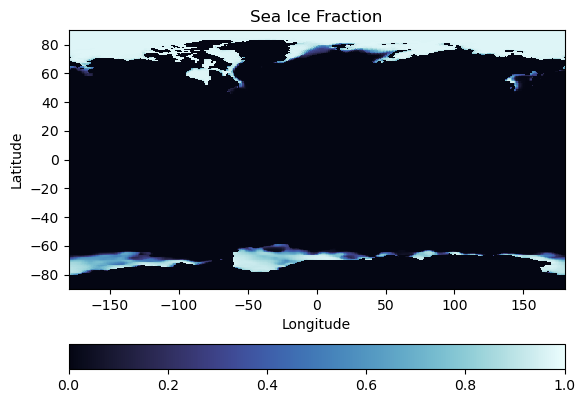

In [6]:
# create a figure object
fig = plt.figure()

# plot the temperature
plt.pcolormesh(longitude, latitude, SIarea, vmin=0, vmax=1, cmap=cm.ice)
plt.colorbar(orientation = 'horizontal')

# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Ice Fraction')
plt.show()
#problem: 0 is continents but 0 also means no sea ice.

Looking at the sea ice data in this view is a little silly because our map is focused on the equator while the sea ice is at the poles. One way we could modify this is by changing the *projection* of our map.

## Part 2: Plotting with Cartopy
When we are working with numerical ocean model data, our numerical models represent locations on the globe. In these situations, it is helpful to plot our data in a projection that represents this aspect of our data. With this in mind, we'll invstigate plotting with the `cartopy` package which refers to **carto**graphy with **py**thon. 

In looking at the plot above, there's at least two things that are dissatisfying. First, the world is very distorted at the poles. Second, the continents are filled in with a default value of 0, which is a the same value given to areas of no sea ice - kinda confusing. We can remedy both of these using `cartopy` by choosing a better projection for our data and adding polygons that cover the coastline. 

Take a look at the plotting code below:

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:712: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:712: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(

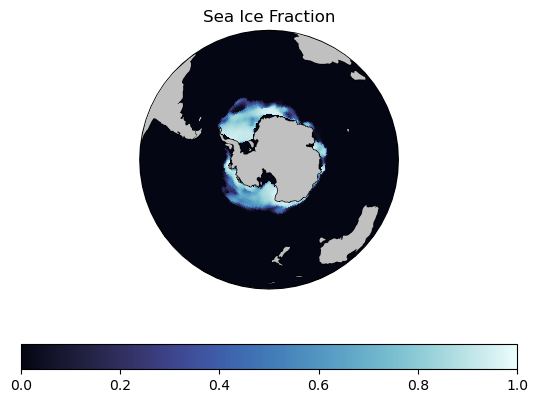

In [7]:
# create a figure object
fig = plt.figure()
# could be 'Orthographic' for round globe or 'Robinson' for flat globe.
# use central_latitude/longitude to rotate.
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-90))

# plot the seaice
plt.pcolormesh(longitude, latitude, SIarea, vmin=0, vmax=1, cmap=cm.ice,
               transform=ccrs.PlateCarree())
plt.colorbar(orientation = 'horizontal')

# add coastlines
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# format the axes
plt.title('Sea Ice Fraction')
plt.show()

### &#x1F914; Spot the differences
What are the key differences between the code that generates the plot above compared to the previous plot?

The diference is that the continents are a different color separate from the scale which was defined by the facecolor in the gca add feature function.

### Projections
As you can see above, the axes object provides the projection system for the map. We see that a `projection` parameter has been set to a specific projection - in this case the `Robinson` projection. The `cartopy` package has a variety of different projections for plotting mapped data. Test some of the following common projections by modifying the plot above:

| Projection Code | Default Parameters |
|-----------------|--------------------|
| PlateCarree()  | central_longitude=0.0 |
| Mollweide()     | central_longitude=0.0 |
| Orthographic()  | central_longitude=0.0, central_latitude=0.0 |
| Robinson()      | central_longitude=0.0 |
| InterruptedGoodeHomolosine() | central_longitude=0.0 |

When you find your favorite projection, try changing the default central longitude/latitude to see how the plot changes.

### &#x2757; Note
In the plot above, the `transform=ccrs.PlateCarree()` keyword is crucial to plotting the data correctly. This line tells `cartopy` that the data is in longitude-latitude coordinates. Without this keyword, there is no way that `cartopy` will know how to put the data on the map.

## Part 2: Figures and Functions
In the subsequent sections, we're going to take a look at how to create movies in Python but first, we're going to build up some machinery to create the frames of our movie. After we've created our frames, it will be easy to string them together into a movie.

First, let's define a function called `plot_frame` to make a plot. This function should take in two input arguments: the sea ice field and a file path.

In [8]:
# adapt the code below in to a function
# called plot_frame that takes SIarea and the file_path as arguments
file_path = 'Frames/SIarea_01.png'

# make a figure object with projection
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude = 80))

# plot the sea ice field
plt.pcolormesh(longitude, latitude, SIarea, vmin=0, vmax=1, cmap=cm.ice,
               transform=ccrs.PlateCarree())
plt.colorbar(orientation = 'horizontal', label='Sea Ice Concentration')

# add coastlines
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# format the axes
plt.title('Sea Ice Fraction')

# save the figure
plt.savefig(file_path)
plt.close(fig)

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:712: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b

Once you're happy with your code, we can test it out with the data we've read in for Jan 15 above:

In [9]:
# called plot_frame that takes SIarea and the file_path as arguments
def plot_frame(SIarea, file_path):
    file_path = file_path
    
    # make a figure object with projection
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.Orthographic(central_latitude = 80))
    
    # plot the sea ice field
    plt.pcolormesh(longitude, latitude, SIarea, vmin=0, vmax=1, cmap=cm.ice,
                   transform=ccrs.PlateCarree())
    plt.colorbar(orientation = 'horizontal', label='Sea Ice Concentration')
    
    # add coastlines
    plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
    plt.gca().coastlines()
    
    # format the axes
    plt.title('Sea Ice Fraction')
    
    # save the figure
    plt.savefig(file_path)
    plt.close(fig)

In [10]:
# define a path to a directory for your frames directory
frames_directory = 'Frames/'

# define an output path for your frame
file_path = os.path.join(frames_directory,'SIarea_2015_01.png')

# test your plotting function here
plot_frame(SIarea, file_path)

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b,

In [12]:
# Make a for loop 
file_list = []
for month in range (1, 13):
    # open each dataset
    # make a path to a sea ice file
    file_name = 'SIarea_2015_' + '{:02d}'.format(month)+'.nc'
    # print(file_name)
    seaice_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                              'interp_monthly','SIarea',file_name)
    ds = xr.open_dataset(seaice_file)
    longitude = np.array(ds['longitude'][:])
    latitude = np.array(ds['latitude'][:])
    SIarea = np.array(ds['SIarea'][:])
    ds.close()
    SIarea = SIarea[0, :, :]
    file_list.append(file_path)
    
    # make a figure for that data
    file_name = 'SIarea_2015_' + '{:02d}'.format(month)+'.png'
    file_path = os.path.join(frames_directory,file_name)
    plot_frame(SIarea, file_path)

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b,

In [13]:
fps = 5

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps = fps)
clip.write_videofile('Artic Sea Ice.mp4')

MoviePy - Building video Artic Sea Ice.mp4.
MoviePy - Writing video Artic Sea Ice.mp4



MoviePy - Done !
MoviePy - video ready Artic Sea Ice.mp4


Now that we've created out images, we're ready to stitch them together to make a movie! We'll tackle this task in class on Tuesday.